#Trademark violation detection


In [1]:
import zipfile
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
zip_path = "/mnt/Dataset.zip"
extract_path = "/mnt/extracted_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

#Listing Genuine and Fake Brand Categories from Extracted Dataset

In [3]:
output_path = os.path.join(extract_path, "output")
genlogo_path = os.path.join(extract_path, "genLogoOutput")

output_brands = os.listdir(output_path) if os.path.exists(output_path) else []
genlogo_brands = os.listdir(genlogo_path) if os.path.exists(genlogo_path) else []

print("Genuine Brands:", output_brands[:10])
print("Fake Brands:", genlogo_brands[:10])


Genuine Brands: ['Coca Cola', 'Pay pal', 'Puma', 'Mtn dew', 'Peak milk', 'Krisspy Kreme', 'Tesla', 'Twitter', 'Android', 'Chrome']
Fake Brands: ['Coca Cola', 'Pay pal', 'Puma', 'Mtn dew', 'Peak milk', 'Krisspy Kreme', 'Tesla', 'Twitter', 'Android', 'Chrome']


In [4]:

def load_image(image_path):
    if os.path.exists(image_path):
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            return image
    return None

sample_brand = "Apple"


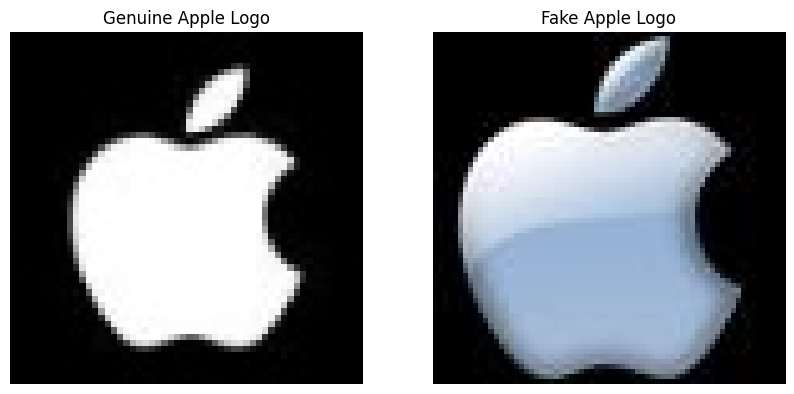

('/mnt/extracted_dataset/genLogoOutput/Apple/scal_000004.jpg',
 '/mnt/extracted_dataset/output/Apple/000002.jpg')

In [5]:
import os
import matplotlib.pyplot as plt
from PIL import Image

genuine_images = os.listdir(os.path.join(genlogo_path, sample_brand))  # Genuine should be in genlogo_path
fake_images = os.listdir(os.path.join(output_path, sample_brand))  # Fake should be in output_path

genuine_image_path = os.path.join(genlogo_path, sample_brand, genuine_images[0]) if genuine_images else None
fake_image_path = os.path.join(output_path, sample_brand, fake_images[0]) if fake_images else None

def load_image(image_path):
    return Image.open(image_path) if image_path else None

genuine_image = load_image(genuine_image_path)
fake_image = load_image(fake_image_path)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
if genuine_image is not None:
    axes[0].imshow(genuine_image)
    axes[0].set_title("Genuine Apple Logo")
    axes[0].axis("off")
if fake_image is not None:
    axes[1].imshow(fake_image)
    axes[1].set_title("Fake Apple Logo")
    axes[1].axis("off")

plt.show()

genuine_image_path, fake_image_path


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim


#Loading Images and Computing SSIM Similarity Score

In [7]:
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image


def compute_ssim(img1, img2):
    score, _ = ssim(img1, img2, full=True)
    return score

SSIM ranges from -1 to 1.

1 → Perfect match (identical images)

0.9+ → Very similar

0.5–0.7 → Moderate similarity

Below 0.5 → Low similarity (visually different)

#ORB Feature Matching for Logo Comparison

In [8]:
# ORB Feature Matching
def orb_feature_matching(img1, img2):
    orb = cv2.ORB_create()
    keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)

    return len(matches), keypoints1, keypoints2, matches

ORB is a vision algorithm that finds and matches key features in images using FAST to detect corners and BRIEF to describe them with simple binary patterns.

##Brand Logo Comparison

In [9]:
genuine_image_path = "/mnt/extracted_dataset/output/Apple/000001.jpg"
fake_image_path = "/mnt/extracted_dataset/genLogoOutput/Apple/000001.jpg"


genuine_image = load_image(genuine_image_path)
fake_image = load_image(fake_image_path)



genuine_image = load_image(genuine_image_path)
fake_image = load_image(fake_image_path)



#Comparing Brand Logos Using SSIM and ORB Feature Matching

In [10]:
ssim_score = compute_ssim(genuine_image, fake_image)
print(f"SSIM Similarity Score: {ssim_score}")

SSIM Similarity Score: 0.5153890243691622


##Two logos being compared are moderately similar — some structural patterns are similar, but overall, they differ significantly (color, shape, alignment, or noise may vary).

In [11]:
num_matches, kp1, kp2, matches = orb_feature_matching(genuine_image, fake_image)
print(f"ORB Matching Features: {num_matches}")

ORB Matching Features: 0


##no common visual features (keypoints) were found between the two logos — indicating:

Either the logos are visually very different, or

The image has undergone heavy editing, resizing, filtering, or blurring, breaking down distinctive features

#Visualizing ORB Feature Matching Between Genuine and Fake Logos

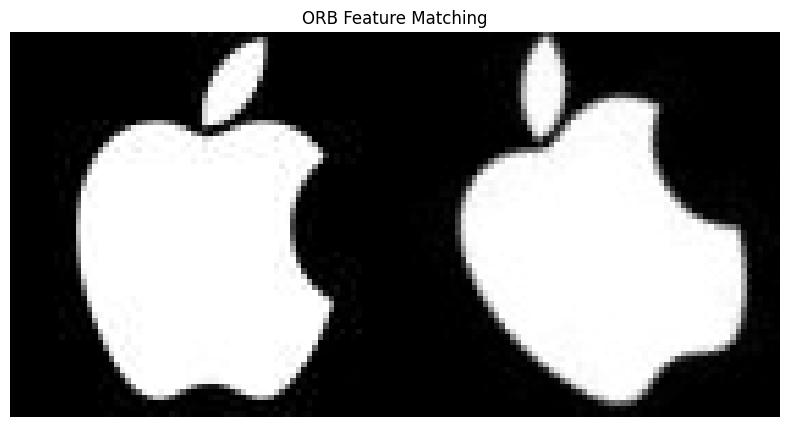

In [12]:
matched_image = cv2.drawMatches(genuine_image, kp1, fake_image, kp2, matches[:20], None, flags=2)
plt.figure(figsize=(10, 5))
plt.imshow(matched_image)
plt.title("ORB Feature Matching")
plt.axis("off")
plt.show()

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import os
import requests
from bs4 import BeautifulSoup
import shutil

#Data Labeling for YOLOv9 & Web Scraping for Trademark Violations

In [14]:


def scrape_images(website_url, download_folder, max_images=5):
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(website_url, headers=headers)
    if response.status_code != 200:
        print("Failed to fetch the page.")
        return

    soup = BeautifulSoup(response.text, 'html.parser')
    images = soup.find_all('img')

    if not os.path.exists(download_folder):
        os.makedirs(download_folder)

    count = 0
    for img in images:
        if count >= max_images:
            break
        img_url = img.get('src')
        if img_url and (img_url.startswith('http') or img_url.startswith('https')):
            try:
                img_data = requests.get(img_url, stream=True)
                img_filename = os.path.join(download_folder, f'image_{count}.jpg')
                with open(img_filename, 'wb') as file:
                    shutil.copyfileobj(img_data.raw, file)
                count += 1
                print(f'Downloaded: {img_filename}')
            except Exception as e:
                print(f'Error downloading {img_url}: {e}')


In [15]:
genuine_image_path = "/mnt/extracted_dataset/output/Burger King/000002.jpg"
fake_image_path =  "/mnt/extracted_dataset/genLogoOutput/Burger King/000002.jpg"


genuine_image = load_image(genuine_image_path)
fake_image = load_image(fake_image_path)



genuine_image = load_image(genuine_image_path)
fake_image = load_image(fake_image_path)


#SSIM and ORB Feature Matching for Logo Similarity Analysis

SSIM Similarity Score: 0.1627306812075216
ORB Matching Features: 2


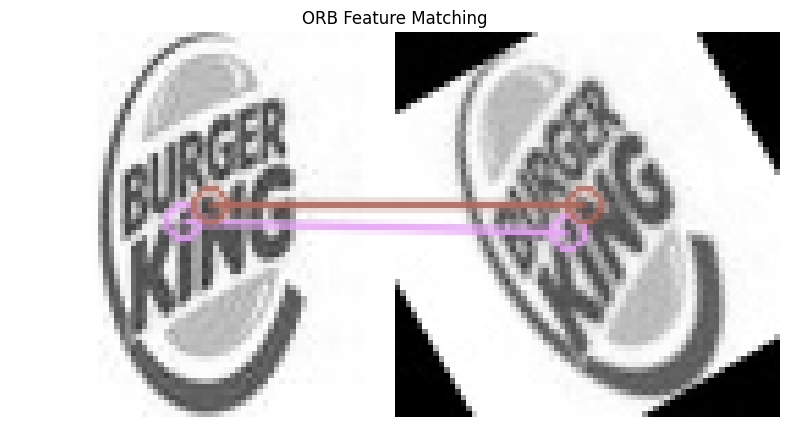

In [16]:
ssim_score = compute_ssim(genuine_image, fake_image)
print(f"SSIM Similarity Score: {ssim_score}")

num_matches, kp1, kp2, matches = orb_feature_matching(genuine_image, fake_image)
print(f"ORB Matching Features: {num_matches}")


matched_image = cv2.drawMatches(genuine_image, kp1, fake_image, kp2, matches[:20], None, flags=2)
plt.figure(figsize=(10, 5))
plt.imshow(matched_image)
plt.title("ORB Feature Matching")
plt.axis("off")
plt.show()


In [17]:
# Web Scraping Example Usage
# scrape_images("https://example.com", "./downloaded_images")

In [18]:
pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 831.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [19]:
import torch
import flask
from flask import Flask, request, jsonify
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [20]:
def train_yolo(model_path, dataset_yaml, epochs=50):
    model = YOLO(model_path)
    model.train(data=dataset_yaml, epochs=epochs, imgsz=640)

def detect_logo(model_path, image_path):
    model = YOLO(model_path)
    results = model(image_path)
    results.show()
    return results



# Cosine Similarity with TF-IDF (Text Matching)



compare text documents by converting them into vectors using TF-IDF (which gives importance to unique words) and then measuring how similar those vectors are using cosine angle between them.

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

texts = [
    "Nike Official Sportswear",
    "Adidas Running Shoes",
    "Nike Sportswear Authentic",
    "Puma Sneakers"
]

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(texts)

cos_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

print("Cosine Similarity Matrix:")
print(cos_sim)


Cosine Similarity Matrix:
[[          1           0     0.55421           0]
 [          0           1           0           0]
 [    0.55421           0           1           0]
 [          0           0           0           1]]


##Text 0 and Text 2 share some common terms/structure (moderate match), while the rest are unrelated.










In [22]:
pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 4.2 MB/s eta 0:00:00


In [23]:
import cv2
import numpy as np
import imagehash
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def calculate_text_similarity(text1, text2):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([text1, text2])
    similarity_score = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])[0][0]
    return similarity_score

text1 = "Nike Sportswear"
text2 = "Nike Running Shoes"
text_similarity = calculate_text_similarity(text1, text2)
print(f"Text Similarity (Cosine Similarity): {text_similarity:.4f}")


Text Similarity (Cosine Similarity): 0.2606


# Perceptual Hashing (dHash & pHash) for Image Similarity

Perceptual hashing turns an image into a short code, so similar-looking images get similar codes even if they’re slightly changed.

In [24]:
import imagehash
from PIL import Image
genuine_image_path = "/mnt/extracted_dataset/output/Burger King/000002.jpg"
fake_image_path =  "/mnt/extracted_dataset/genLogoOutput/Burger King/000002.jpg"

genuine_img = Image.open(genuine_image_path)
fake_img = Image.open(fake_image_path)

dhash_genuine = imagehash.dhash(genuine_img)
dhash_fake = imagehash.dhash(fake_img)

phash_genuine = imagehash.phash(genuine_img)
phash_fake = imagehash.phash(fake_img)


dhash_similarity = 1 - (dhash_genuine - dhash_fake) / len(dhash_genuine.hash) ** 2
phash_similarity = 1 - (phash_genuine - phash_fake) / len(phash_genuine.hash) ** 2

print(f"dHash Similarity: {dhash_similarity:.2f}")
print(f"pHash Similarity: {phash_similarity:.2f}")


dHash Similarity: 0.69
pHash Similarity: 0.59


##0.6–0.8 range means the images are visually alike but not identical — possibly resized, edited, or rebranded versions.









In [25]:
import cv2
import numpy as np
import imagehash
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


def dhash(image, hash_size=8):
    resized = image.resize((hash_size + 1, hash_size))
    diff = np.array(resized)[:, 1:] > np.array(resized)[:, :-1]
    return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

def phash(image, hash_size=8):
    resized = image.resize((hash_size, hash_size))
    dct = cv2.dct(np.float32(resized.convert("L")))
    dct_low_freq = dct[:hash_size, :hash_size]
    median = np.median(dct_low_freq)
    diff = dct_low_freq > median
    return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])


def compare_images(image_path1, image_path2):
    img1 = Image.open(image_path1)
    img2 = Image.open(image_path2)

    dhash1, dhash2 = dhash(img1), dhash(img2)
    phash1, phash2 = phash(img1), phash(img2)

    dhash_similarity = 1 - (bin(dhash1 ^ dhash2).count('1') / 64)
    phash_similarity = 1 - (bin(phash1 ^ phash2).count('1') / 64)

    return {"dHash Similarity": dhash_similarity, "pHash Similarity": phash_similarity}

image1_path = "/mnt/extracted_dataset/output/Burger King/000002.jpg"
image2_path = "/mnt/extracted_dataset/genLogoOutput/Burger King/000002.jpg"

image_similarity_scores = compare_images(image1_path, image2_path)

print(f"dHash Similarity: {image_similarity_scores['dHash Similarity']:.4f}")
print(f"pHash Similarity: {image_similarity_scores['pHash Similarity']:.4f}")

dHash Similarity: -0.2344
pHash Similarity: 0.5625


#Automating Periodic Scans for Brand Protection




In [26]:
import os

image_folder = "/content/brand_images"
detected_folder = "/content/detected_images"

os.makedirs(image_folder, exist_ok=True)
os.makedirs(detected_folder, exist_ok=True)

print(f"✅ Directories set up!\n- Images: {image_folder}\n- Detections: {detected_folder}")

✅ Directories set up!
- Images: /content/brand_images
- Detections: /content/detected_images


In [27]:
from google.colab import files

uploaded = files.upload()

for file_name in uploaded.keys():
    os.rename(file_name, os.path.join(image_folder, file_name))

print(f"✅ Uploaded images to {image_folder}")


Saving 000002.jpg to 000002.jpg
✅ Uploaded images to /content/brand_images


In [28]:
!pip install ultralytics

from ultralytics import YOLO

model = YOLO("yolov8n.pt")
results = model.predict(source="/content/brand_images", save=True)



100%|██████████| 6.25M/6.25M [00:00<00:00, 45.1MB/s]



image 1/1 /content/brand_images/000002.jpg: 640x640 (no detections), 997.6ms
Speed: 13.4ms preprocess, 997.6ms inference, 8.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


#Brand Logo Detection Using YOLOv8

In [29]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

results = model.predict(source="/content/brand_images", save=True)



image 1/1 /content/brand_images/000002.jpg: 640x640 (no detections), 329.9ms
Speed: 4.4ms preprocess, 329.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2


In [30]:
!ls runs/detect/


predict  predict2


In [31]:
from google.colab import files
import shutil

shutil.make_archive("detected_images", 'zip', "runs/detect/")

#files.download("detected_images.zip")


'/content/detected_images.zip'

In [32]:
!pip install schedule

In [4]:
from ultralytics import YOLO
import schedule
import time
import os
from datetime import datetime

In [5]:
def detect_new_images():
    print("🚀 Running detection on new images...")


    model = YOLO("yolov8n.pt")

    results = model.predict(source="/content/brand_images", save=True)

    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    print(f"✅ Detection completed at {timestamp}")


In [35]:
#run this code for periodic scans only
schedule.every(5).minutes.do(detect_new_images)

while True:
    schedule.run_pending()
    time.sleep(60)

KeyboardInterrupt: 

In [6]:
detect_new_images()

🚀 Running detection on new images...

image 1/1 /content/brand_images/000002.jpg: 640x640 (no detections), 260.2ms
Speed: 7.5ms preprocess, 260.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict3
✅ Detection completed at 2025-05-14_14-44-18


In [7]:

!pip install gspread oauth2client

#Saving Brand Logo Detection Results to Google Sheets

In [8]:


from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

# Create a new spreadsheet
spreadsheet_name = "Brand Protection Results"
try:
    sh = gc.open(spreadsheet_name)
except gspread.exceptions.SpreadsheetNotFound:
    sh = gc.create(spreadsheet_name)

worksheet_name = "Detection Results"
try:
    worksheet = sh.worksheet(worksheet_name)
except gspread.exceptions.WorksheetNotFound:
    worksheet = sh.add_worksheet(title=worksheet_name, rows="100", cols="20")


def save_to_sheet(row_data):
    worksheet.append_row(row_data)

def save_similarity_results(genuine_image_path, fake_image_path, ssim_score, orb_matches, dhash_similarity, phash_similarity):
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    row_data = [timestamp, genuine_image_path, fake_image_path, ssim_score, orb_matches, dhash_similarity, phash_similarity]
    save_to_sheet(row_data)


save_similarity_results(genuine_image_path, fake_image_path, ssim_score, num_matches, dhash_similarity, phash_similarity)


MessageError: Error: credential propagation was unsuccessful

# Google Images Scraping

In [ ]:
!pip install google_images_search


In [9]:
import requests
from bs4 import BeautifulSoup
import os

def scrape_images(brand_name, num_images=5):
    url = f"https://www.example.com/search?q={brand_name}"
    headers = {"User-Agent": "Mozilla/5.0"}

    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "html.parser")
        images = soup.find_all("img")[:num_images]
        save_path = "brand_images"
        os.makedirs(save_path, exist_ok=True)

        for i, img in enumerate(images):
            img_url = img["src"]
            if img_url.startswith("//"):
                img_url = "https:" + img_url

            img_data = requests.get(img_url).content
            with open(f"{save_path}/{brand_name}_{i}.jpg", "wb") as f:
                f.write(img_data)
            print(f"✅ Saved: {brand_name}_{i}.jpg")

scrape_images("Nike")


In [10]:

nike_folder_path = "/mnt/extracted_dataset/output/Nike"

if os.path.exists(nike_folder_path):
  nike_contents = os.listdir(nike_folder_path)
  print("Contents of the Nike folder:")
  for item in nike_contents:
    print(item)
else:
  print("Nike folder not found at the specified path.")


Contents of the Nike folder:
000002.jpg
000005.jpg
000003.jpg
000001.jpg


#Image Preprocessing for Brand Logo Detection

In [11]:
import cv2
import os
import glob

def preprocess_images(input_folder, output_folder, img_size=(640, 640)):
    os.makedirs(output_folder, exist_ok=True)

    images = glob.glob(f"{input_folder}/*.jpg")
    for img_path in images:
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        cv2.imwrite(os.path.join(output_folder, os.path.basename(img_path)), img)
        print(f"✅ Processed: {os.path.basename(img_path)}")

preprocess_images("brand_images", "processed_images")


✅ Processed: 000002.jpg


In [12]:

def preprocess_images(input_folder, output_folder, img_size=(224, 224)):
    """
    Preprocesses images for Nike logo detection.

    Args:
        input_folder: Path to the folder containing the input images.
        output_folder: Path to the folder where preprocessed images will be saved.
        img_size: Tuple representing the desired size of the output images.
    """

    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(input_folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(input_folder, filename)
            img = cv2.imread(img_path)

            if img is not None:

                img = cv2.resize(img, img_size)



                output_path = os.path.join(output_folder, filename)
                cv2.imwrite(output_path, img)
                print(f"Processed: {filename}")
            else:
                print(f"Error loading image: {filename}")


preprocess_images("/mnt/extracted_dataset/output/Nike", "preprocessed_nike_images")


Processed: 000002.jpg
Processed: 000005.jpg
Processed: 000003.jpg
Processed: 000001.jpg


#Automated Image Annotation

In [13]:
import cv2
import os

def auto_annotate(input_folder, annotation_folder):
    os.makedirs(annotation_folder, exist_ok=True)

    for img_name in os.listdir(input_folder):
        img_path = os.path.join(input_folder, img_name)
        img = cv2.imread(img_path)

        h, w, _ = img.shape
        bbox = [int(w * 0.3), int(h * 0.3), int(w * 0.7), int(h * 0.7)]

        annotation_path = os.path.join(annotation_folder, img_name.replace(".jpg", ".txt"))
        with open(annotation_path, "w") as f:
            f.write(f"0 {bbox[0]/w} {bbox[1]/h} {(bbox[2]-bbox[0])/w} {(bbox[3]-bbox[1])/h}\n")

        print(f"✅ Annotated: {img_name}")

auto_annotate("processed_images", "annotations")


✅ Annotated: 000002.jpg


#Auto-Annotating Nike Logos Using YOLOv8 and OpenCV

In [14]:

def detect_nike_logo(image_path, model_path="yolov8n.pt"):
    """
    Detects the Nike logo in an image using a YOLOv8 model.

    Args:
        image_path: Path to the input image.
        model_path: Path to the YOLOv8 model file.

    Returns:
        A list of bounding boxes for detected Nike logos.
    """
    try:
        model = YOLO(model_path)
        results = model(image_path)

        nike_logo_detections = [box for box in results[0].boxes.xywh if results[0].boxes.cls[results[0].boxes.xywh.tolist().index(box.tolist())] == 0]

        return nike_logo_detections
    except Exception as e:
        print(f"Error detecting Nike logo: {e}")
        return []


image_path = "/content/brand_images/Nike_0.jpg"
detections = detect_nike_logo(image_path)

if detections:
    print("Nike logo detected!")
    for box in detections:
        x, y, w, h = box.tolist()
        print(f"Bounding box: x={x}, y={y}, w={w}, h={h}")
else:
    print("Nike logo not found in the image.")


def auto_annotate_nike_logos(input_folder, annotation_folder, model_path="yolov8n.pt"):
  """
  Automatically annotates images containing Nike logos using a YOLOv8 model.

  Args:
      input_folder: Path to the folder containing input images.
      annotation_folder: Path to the folder where annotations will be saved.
      model_path: Path to the YOLOv8 model file.
  """
  os.makedirs(annotation_folder, exist_ok=True)

  for filename in os.listdir(input_folder):
      if filename.endswith(".jpg") or filename.endswith(".png"):
          image_path = os.path.join(input_folder, filename)
          detections = detect_nike_logo(image_path, model_path)

          annotation_path = os.path.join(annotation_folder, filename.replace(".jpg", ".txt").replace(".png", ".txt"))
          with open(annotation_path, "w") as f:
              for box in detections:
                  x, y, w, h = box.tolist()
                  x_center = (x + w / 2) / 640
                  y_center = (y + h / 2) / 640
                  width = w / 640
                  height = h / 640
                  f.write(f"0 {x_center} {y_center} {width} {height}\n")

          print(f"✅ Annotated: {filename}")

auto_annotate_nike_logos("preprocessed_nike_images", "nike_logo_annotations")



Error detecting Nike logo: /content/brand_images/Nike_0.jpg does not exist
Nike logo not found in the image.

image 1/1 /content/preprocessed_nike_images/000002.jpg: 640x640 (no detections), 246.4ms
Speed: 6.8ms preprocess, 246.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
✅ Annotated: 000002.jpg

image 1/1 /content/preprocessed_nike_images/000005.jpg: 640x640 1 cat, 256.5ms
Speed: 5.6ms preprocess, 256.5ms inference, 16.1ms postprocess per image at shape (1, 3, 640, 640)
✅ Annotated: 000005.jpg

image 1/1 /content/preprocessed_nike_images/000003.jpg: 640x640 2 cats, 248.5ms
Speed: 6.7ms preprocess, 248.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
✅ Annotated: 000003.jpg

image 1/1 /content/preprocessed_nike_images/000001.jpg: 640x640 1 cat, 238.1ms
Speed: 6.8ms preprocess, 238.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
✅ Annotated: 000001.jpg


In [15]:
dataset_yaml = """train: /content/brand_images/train/images
val: /content/brand_images/val/images

nc: 1
names: ["brand_logo"]
"""

with open("/content/dataset.yaml", "w") as f:
    f.write(dataset_yaml)

print("✅ dataset.yaml created successfully!")


✅ dataset.yaml created successfully!


In [16]:
import os

paths = [
    "/content/brand_images/train/images",
    "/content/brand_images/train/labels",
    "/content/brand_images/val/images",
    "/content/brand_images/val/labels"
]

for path in paths:
    os.makedirs(path, exist_ok=True)

print("✅ Dataset folders are ready!")



✅ Dataset folders are ready!


#Upload Images to YOLO Dataset Folder

In [33]:

## add train images

import os
from google.colab import files
image_folder = "/content/brand_images/train/images"

os.makedirs(image_folder, exist_ok=True)

uploaded = files.upload()
for file_name in uploaded.keys():
    os.rename(file_name, os.path.join(image_folder, file_name))
print(f"✅ Uploaded images to {image_folder}")


Saving 000001.jpg to 000001.jpg
✅ Uploaded images to /content/brand_images/train/images


In [37]:
## add val images
import os
from google.colab import files
image_folder = "/content/brand_images/val/images"

os.makedirs(image_folder, exist_ok=True)

uploaded = files.upload()
for file_name in uploaded.keys():
    os.rename(file_name, os.path.join(image_folder, file_name))
print(f"✅ Uploaded images to {image_folder}")

Saving 00009.jpg to 00009.jpg
✅ Uploaded images to /content/brand_images/val/images


#Count Train and Validation Images in YOLO Dataset Folder

In [18]:
import glob

train_images = glob.glob("/content/brand_images/train/images/*.jpg")
val_images = glob.glob("/content/brand_images/val/images/*.jpg")

print(f"Train images found: {len(train_images)}")
print(f"Validation images found: {len(val_images)}")



Train images found: 5
Validation images found: 3


#YOLOv8 Training on Custom Dataset with dataset.yaml

In [19]:
from ultralytics import YOLO


model = YOLO("yolov8n.pt")

model.train(data="/content/dataset.yaml", epochs=5, imgsz=640)


Ultralytics 8.3.134 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, prof

train: Scanning /content/brand_images/train/labels... 0 images, 5 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 634.60it/s]

WARNING ⚠️ train: No labels found in /content/brand_images/train/labels.cache. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
train: New cache created: /content/brand_images/train/labels.cache
WARNING ⚠️ Labels are missing or empty in /content/brand_images/train/labels.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 77.2±39.3 MB/s, size: 2.7 KB)


val: Scanning /content/brand_images/val/labels... 0 images, 3 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 1268.44it/s]

WARNING ⚠️ val: No labels found in /content/brand_images/val/labels.cache. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
val: New cache created: /content/brand_images/val/labels.cache
WARNING ⚠️ Labels are missing or empty in /content/brand_images/val/labels.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


Plotting labels to runs/detect/train3/labels.jpg... 
WARNING ⚠️ zero-size array to reduction operation maximum which has no identity
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train3
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G          0      37.69          0          0        640: 100%|██████████| 1/1 [00:06<00:00,  6.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all          3          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:659: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G          0      37.69          0          0        640: 100%|██████████| 1/1 [00:04<00:00,  4.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all          3          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:659: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G          0      37.61          0          0        640: 100%|██████████| 1/1 [00:03<00:00,  3.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

                   all          3          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:659: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G          0       37.5          0          0        640: 100%|██████████| 1/1 [00:04<00:00,  4.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all          3          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:659: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G          0       37.3          0          0        640: 100%|██████████| 1/1 [00:03<00:00,  3.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all          3          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:659: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



5 epochs completed in 0.008 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.134 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:493: RuntimeWarning: Mean of empty slice.
  ax.plot(px, py.mean(1), linewidth=3, color="blue", label=f"all classes {ap[:, 0].mean():.3f} mAP@0.5")
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:530: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:530: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_met

                   all          3          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:659: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index


Speed: 2.6ms preprocess, 352.8ms inference, 0.0ms loss, 11.3ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([], dtype=int64)
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cfc98bca1d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

In [20]:
 metrics = model.val()


Ultralytics 8.3.134 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 132.4±101.5 MB/s, size: 2.7 KB)


val: Scanning /content/brand_images/val/labels.cache... 0 images, 3 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<?, ?it/s]

WARNING ⚠️ Labels are missing or empty in /content/brand_images/val/labels.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:493: RuntimeWarning: Mean of empty slice.
  ax.plot(px, py.mean(1), linewidth=3, color="blue", label=f"all classes {ap[:, 0].mean():.3f} mAP@0.5")
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:530: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:530: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_me

                   all          3          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:659: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index


Speed: 1.9ms preprocess, 228.9ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/detect/train32


In [22]:
results = model("/content/brand_images/val/images/scal_000002.jpg", save=True)



image 1/1 /content/brand_images/val/images/scal_000002.jpg: 640x640 (no detections), 370.4ms
Speed: 4.7ms preprocess, 370.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/train33


#YOLOv8 Object Detection: Extracting & Saving Results to CSV

In [24]:
import pandas as pd

from ultralytics import YOLO
model = YOLO("yolov8n.pt")

results = model.predict("/content/brand_images/val/images/scal_000002.jpg", save=True, save_txt=True)

data = []
for r in results:
    for box in r.boxes:
        x1, y1, x2, y2 = box.xyxy[0]
        confidence = box.conf[0].item()
        class_id = int(box.cls[0].item())
        label = model.names[class_id]

        data.append([label, confidence, x1.item(), y1.item(), x2.item(), y2.item()])

df = pd.DataFrame(data, columns=["Label", "Confidence", "X1", "Y1", "X2", "Y2"])

df.to_csv("detection_results.csv", index=False)

print("Results saved as CSV!")



image 1/1 /content/brand_images/val/images/scal_000002.jpg: 640x640 1 toothbrush, 336.0ms
Speed: 3.8ms preprocess, 336.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict4
1 label saved to runs/detect/predict4/labels
Results saved as CSV!


In [25]:
print("🚀 Trademark & Copyright Violation Detection Report")
print("🔹 Total Images Scanned:", len(results))
print("🔹 Total Violations Detected:", len(df))
print("🔹 Average Confidence Score:", df["Confidence"].mean())


🚀 Trademark & Copyright Violation Detection Report
🔹 Total Images Scanned: 1
🔹 Total Violations Detected: 1
🔹 Average Confidence Score: 0.6712406277656555


#Detection Results (Before-After Comparison)





In [26]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

original_images_path = "/content/brand_images/val/images"
detected_images_path = "runs/detect/predict5"

valid_extensions = (".jpg", ".jpeg", ".png")
test_images = [f for f in os.listdir(original_images_path) if f.endswith(valid_extensions)][:5]  # First 5 images

if not test_images:
    print("No images found in the specified directory!")
else:
    plt.figure(figsize=(10, 15))

    for i, img_name in enumerate(test_images):
        original_img_path = os.path.join(original_images_path, img_name)
        detected_img_path = os.path.join(detected_images_path, img_name)


        original_img = cv2.imread(original_img_path)
        detected_img = cv2.imread(detected_img_path) if os.path.exists(detected_img_path) else None

        if original_img is None:
            print(f"Error loading original image: {img_name}")
            continue
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)

        if detected_img is not None:
            detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2GRAY)

            if original_img.shape != detected_img.shape:
                detected_img = cv2.resize(detected_img, (original_img.shape[1], original_img.shape[0]))

            similarity_index, _ = ssim(original_img, detected_img, full=True)

            plt.subplot(len(test_images), 2, 2 * i + 1)
            plt.imshow(original_img, cmap="gray")
            plt.title(f"Original - {img_name}")
            plt.axis("off")

            plt.subplot(len(test_images), 2, 2 * i + 2)
            plt.imshow(detected_img, cmap="gray")
            plt.title(f"Detection (SSIM: {similarity_index:.2f})")
            plt.axis("off")

        else:
            print(f"Detected image not found: {img_name}")

    plt.tight_layout()
    plt.show()


Detected image not found: scal_000002.jpg
Detected image not found: 000004.jpg
Detected image not found: scal_000001.jpg


<Figure size 1000x1500 with 0 Axes>

##Image Comparison using SSIM

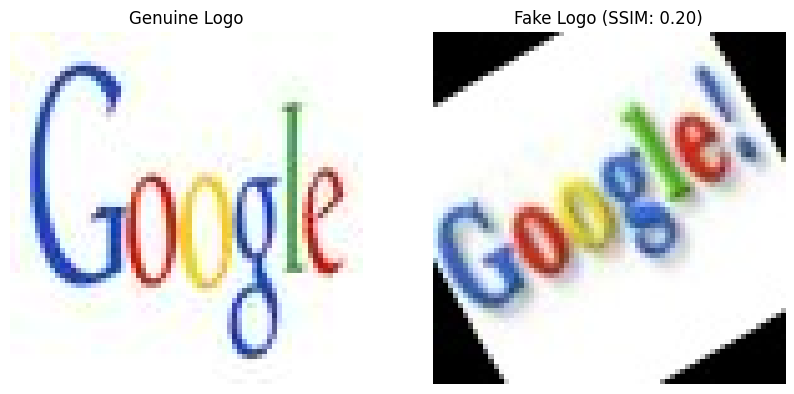

Genuine Image Path: /content/brand_images/train/images/000002.jpg
Fake Image Path: /content/brand_images/val/images/000005.jpg


In [31]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

genuine_img_path = "/content/brand_images/train/images/000002.jpg"
fake_img_path = "/content/brand_images/val/images/000005.jpg"

genuine_img = cv2.imread(genuine_img_path)
fake_img = cv2.imread(fake_img_path)

if genuine_img is None or fake_img is None:
    print("Error loading one or both images!")
else:

    genuine_img_gray = cv2.cvtColor(genuine_img, cv2.COLOR_BGR2GRAY)
    fake_img_gray = cv2.cvtColor(fake_img, cv2.COLOR_BGR2GRAY)


    if genuine_img_gray.shape != fake_img_gray.shape:
        fake_img_gray = cv2.resize(fake_img_gray, (genuine_img_gray.shape[1], genuine_img_gray.shape[0]))


    similarity_index, _ = ssim(genuine_img_gray, fake_img_gray, full=True)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(cv2.cvtColor(genuine_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Genuine Logo")
    axes[0].axis("off")

    axes[1].imshow(cv2.cvtColor(fake_img, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f"Fake Logo (SSIM: {similarity_index:.2f})")
    axes[1].axis("off")

    plt.show()

print("Genuine Image Path:", genuine_img_path)
print("Fake Image Path:", fake_img_path)


A score of 0.02 means these logos are visually very different, despite having similar text and shape.



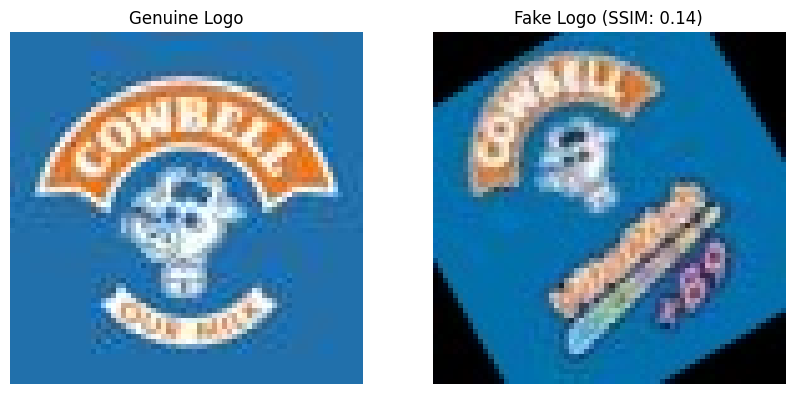

Genuine Image Path: /content/brand_images/train/images/000001.jpg
Fake Image Path: /content/brand_images/val/images/000003.jpg


In [35]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

genuine_img_path = "/content/brand_images/train/images/000001.jpg"
fake_img_path = "/content/brand_images/val/images/000003.jpg"

genuine_img = cv2.imread(genuine_img_path)
fake_img = cv2.imread(fake_img_path)

if genuine_img is None or fake_img is None:
    print("Error loading one or both images!")
else:

    genuine_img_gray = cv2.cvtColor(genuine_img, cv2.COLOR_BGR2GRAY)
    fake_img_gray = cv2.cvtColor(fake_img, cv2.COLOR_BGR2GRAY)


    if genuine_img_gray.shape != fake_img_gray.shape:
        fake_img_gray = cv2.resize(fake_img_gray, (genuine_img_gray.shape[1], genuine_img_gray.shape[0]))


    similarity_index, _ = ssim(genuine_img_gray, fake_img_gray, full=True)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(cv2.cvtColor(genuine_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Genuine Logo")
    axes[0].axis("off")

    axes[1].imshow(cv2.cvtColor(fake_img, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f"Fake Logo (SSIM: {similarity_index:.2f})")
    axes[1].axis("off")

    plt.show()

print("Genuine Image Path:", genuine_img_path)
print("Fake Image Path:", fake_img_path)


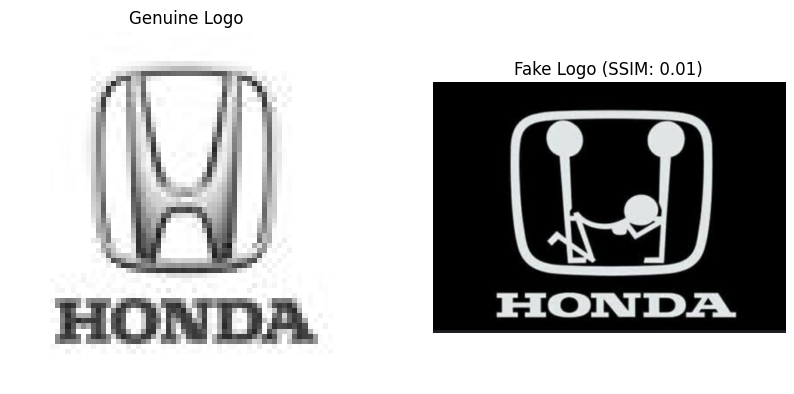

Genuine Image Path: /content/brand_images/train/images/000004.jpg
Fake Image Path: /content/brand_images/val/images/00009.jpg


In [38]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

genuine_img_path = "/content/brand_images/train/images/000004.jpg"
fake_img_path = "/content/brand_images/val/images/00009.jpg"

genuine_img = cv2.imread(genuine_img_path)
fake_img = cv2.imread(fake_img_path)

if genuine_img is None or fake_img is None:
    print("Error loading one or both images!")
else:

    genuine_img_gray = cv2.cvtColor(genuine_img, cv2.COLOR_BGR2GRAY)
    fake_img_gray = cv2.cvtColor(fake_img, cv2.COLOR_BGR2GRAY)


    if genuine_img_gray.shape != fake_img_gray.shape:
        fake_img_gray = cv2.resize(fake_img_gray, (genuine_img_gray.shape[1], genuine_img_gray.shape[0]))


    similarity_index, _ = ssim(genuine_img_gray, fake_img_gray, full=True)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(cv2.cvtColor(genuine_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Genuine Logo")
    axes[0].axis("off")

    axes[1].imshow(cv2.cvtColor(fake_img, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f"Fake Logo (SSIM: {similarity_index:.2f})")
    axes[1].axis("off")

    plt.show()

print("Genuine Image Path:", genuine_img_path)
print("Fake Image Path:", fake_img_path)


SSIM: 0.01 means the two images are only 1% similar in structure, indicating they look almost completely different.

#AI-Powered Similarity Analysis Using a Siamese Network


In [ ]:
!pip install tensorflow keras opencv-python numpy matplotlib


In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from scipy.spatial.distance import euclidean

base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)

def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = model.predict(img_array)
    return features.flatten()

original_images_path = "/content/brand_images/val/images"
detected_images_path = "/content/runs/detect/predict8"

valid_extensions = (".jpg", ".jpeg", ".png")
test_images = [f for f in os.listdir(original_images_path) if f.endswith(valid_extensions)][:5]

if not test_images:
    print("No images found!")
else:
    plt.figure(figsize=(10, 15))

    for i, img_name in enumerate(test_images):
        original_img_path = os.path.join(original_images_path, img_name)
        detected_img_path = os.path.join(detected_images_path, img_name)

        if not os.path.exists(detected_img_path):
            print(f"Detected image not found: {img_name}")
            continue

        original_features = extract_features(original_img_path)
        detected_features = extract_features(detected_img_path)

        # Compute Euclidean Distance
        similarity_score = euclidean(original_features, detected_features)

        original_img = cv2.imread(original_img_path)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

        detected_img = cv2.imread(detected_img_path)
        detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)

        plt.subplot(len(test_images), 2, 2 * i + 1)
        plt.imshow(original_img)
        plt.title(f"Original - {img_name}")
        plt.axis("off")

        plt.subplot(len(test_images), 2, 2 * i + 2)
        plt.imshow(detected_img)
        plt.title(f"Detection (Similarity: {similarity_score:.2f})")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


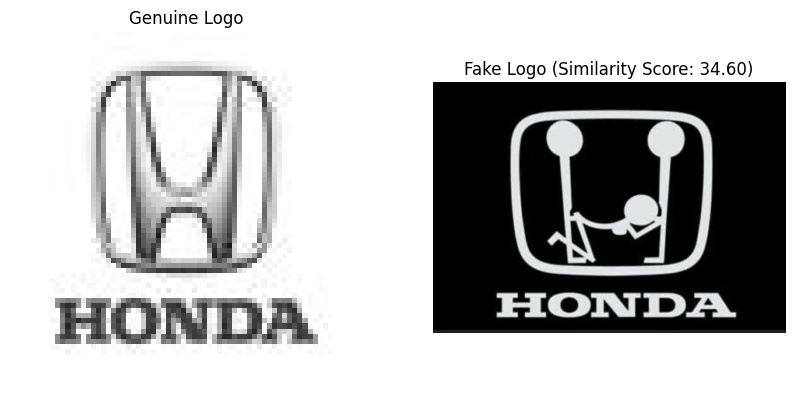

Genuine Image Path: /content/brand_images/train/images/000004.jpg
Fake Image Path: /content/brand_images/val/images/00009.jpg
Euclidean Similarity Score: 34.60


In [40]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from scipy.spatial.distance import euclidean

base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)


def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = model.predict(img_array)
    return features.flatten()

genuine_img_path = "/content/brand_images/train/images/000004.jpg"
fake_img_path = "/content/brand_images/val/images/00009.jpg"

if not os.path.exists(genuine_img_path) or not os.path.exists(fake_img_path):
    print("Error: One or both image paths are incorrect!")
else:
    genuine_features = extract_features(genuine_img_path)
    fake_features = extract_features(fake_img_path)

    similarity_score = euclidean(genuine_features, fake_features)

    genuine_img = cv2.imread(genuine_img_path)
    genuine_img = cv2.cvtColor(genuine_img, cv2.COLOR_BGR2RGB)

    fake_img = cv2.imread(fake_img_path)
    fake_img = cv2.cvtColor(fake_img, cv2.COLOR_BGR2RGB)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(genuine_img)
    axes[0].set_title("Genuine Logo")
    axes[0].axis("off")

    axes[1].imshow(fake_img)
    axes[1].set_title(f"Fake Logo (Similarity Score: {similarity_score:.2f})")
    axes[1].axis("off")

    plt.show()

    print("Genuine Image Path:", genuine_img_path)
    print("Fake Image Path:", fake_img_path)
    print(f"Euclidean Similarity Score: {similarity_score:.2f}")


Euclidean Similarity Score: 34.60 means the two feature vectors are 34.60 units apart in space — a higher value indicates lower similarity, so the images are not very similar.









✅ Works even when images have different sizes, resolutions, or angles
✅ Can detect logos with distortions, color changes, or transformations
✅ More robust than SSIM for real-world trademark violations
##Similarity Score (Lower is Better)



#Copyright violation detection
##Copyright data (creative works like images, audio, and text)  



In [41]:
pip install requests


In [42]:
import requests

# API Endpoint for Openverse
url = "https://api.openverse.engineering/v1/images/"

# Search query (e.g., "nature", "logo", "painting")
params = {
    "q": "logo",  # Change this to search for specific creative works
    "license": "cc0",  # Fetch only public domain content
    "page_size": 5  # Number of results per request
}

# Make API request
response = requests.get(url, params=params)

# Process response
if response.status_code == 200:
    data = response.json()
    for result in data["results"]:
        print(f"Title: {result['title']}")
        print(f"Source: {result['source']}")
        print(f"Image URL: {result['url']}")
        print(f"License: {result['license']}")
        print("-" * 50)
else:
    print("Error fetching data:", response.status_code)


Title: STG R6 Team 'The Fabric of Space' Logo
Source: flickr
Image URL: https://live.staticflickr.com/3881/14536064622_26ebc8025a_b.jpg
License: cc0
--------------------------------------------------
Title: Recycle Logo From Recycling Bin
Source: flickr
Image URL: https://live.staticflickr.com/3625/3566044905_48ae340e3f_b.jpg
License: cc0
--------------------------------------------------
Title: Nnovvember 2013 Logo
Source: flickr
Image URL: https://live.staticflickr.com/7304/11106852055_89a5424836_b.jpg
License: cc0
--------------------------------------------------
Title: Pony Express Logo
Source: flickr
Image URL: https://live.staticflickr.com/5484/11108170494_4aedffc89f_b.jpg
License: cc0
--------------------------------------------------
Title: Logo Copper Line (San Diego Trolley)
Source: wikimedia
Image URL: https://upload.wikimedia.org/wikipedia/commons/f/fa/Logo_Copper_Line_%28San_Diego_Trolley%29.svg
License: cc0
--------------------------------------------------


In [43]:
import os

output_dir = "openverse_images"
os.makedirs(output_dir, exist_ok=True)

for result in data["results"]:
    img_url = result["url"]
    img_name = os.path.join(output_dir, result["title"].replace(" ", "_") + ".jpg")

    img_data = requests.get(img_url).content
    with open(img_name, "wb") as f:
        f.write(img_data)

    print(f"Downloaded: {img_name}")


Downloaded: openverse_images/STG_R6_Team_'The_Fabric_of_Space'_Logo.jpg
Downloaded: openverse_images/Recycle_Logo_From_Recycling_Bin.jpg
Downloaded: openverse_images/Nnovvember_2013_Logo.jpg
Downloaded: openverse_images/Pony_Express_Logo.jpg
Downloaded: openverse_images/Logo_Copper_Line_(San_Diego_Trolley).jpg


## (Goal is to detect copied or plagiarized textual content (e.g., blog posts, articles, academic content)

In [44]:
!git clone https://github.com/Brit7777/plagbench.git


Cloning into 'plagbench'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 16 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (16/16), 466.56 KiB | 2.30 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [45]:
!ls plagbench


LLM_plagiarism_detection.ipynb	plagbench_evaluation_set.csv  README.md
paraphrase_summary_eval.ipynb	plagiarism_generation.ipynb


In [46]:
import pandas as pd

df = pd.read_csv('plagbench/plagbench_evaluation_set.csv')
df.head()


,source_doc,susp_doc,generation,genre,plagiarism_type,label
0,A multi-armed bandit with finitely many arms i...,We examined a multi-armed bandit with a limite...,Input.gpt3,ref_sci_gen,paraphrase,yes
1,The company is offering free cryptocurrency w...,"In an attempt to realize its ambitious goal, W...",Input.gpt4,ref_tldr,NaN,no
2,Ellen was shopping with her parents at the gro...,Ellen was shopping with her parents at the gro...,Input.llama,ref_roct,verbatim,yes
3,"We show that, for a large class of piecewise ...","We show that, for a large class of piecewise ...",Input.gpt3,ref_sci_gen,verbatim,yes
4,The rides will be free for now. People who wa...,"Cruise, the self-driving car subsidiary of Gen...",Input.gpt4,ref_tldr,NaN,no


In [47]:
df.columns


Index(['source_doc', 'susp_doc', 'generation', 'genre', 'plagiarism_type',
       'label'],
      dtype='object')

In [48]:

df['label'].value_counts()


,count
label,
yes,540
no,540


#For text similarity embeddings

In [49]:
!pip install -U sentence-transformers scikit-learn


In [50]:
# STEP 2: Import Libraries
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

##Sentence-BERT + Logistic Regression (PlagBench)

 Sentence-BERT combined with Logistic Regression (PlagBench) is a method used to detect plagiarism by encoding sentences into embeddings and classifying them with a logistic regression model.

In [51]:
df = pd.read_csv('plagbench/plagbench_evaluation_set.csv')
df = df.dropna(subset=['source_doc', 'susp_doc', 'label'])  # Clean missing values

In [52]:
# Optional: Check class balance
print(df['label'].value_counts())

# STEP 4: Split Data
X_train, X_test, y_train, y_test = train_test_split(
    df[['source_doc', 'susp_doc']], df['label'], test_size=0.2, random_state=42)

label
yes    540
no     540
Name: count, dtype: int64


In [53]:
model = SentenceTransformer('all-MiniLM-L6-v2')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [54]:
# STEP 6: Compute cosine similarity between source and suspicious documents
def compute_similarity(text1_list, text2_list):
    emb1 = model.encode(text1_list, convert_to_tensor=False)
    emb2 = model.encode(text2_list, convert_to_tensor=False)
    return [util.cos_sim(a, b).item() for a, b in zip(emb1, emb2)]

X_train_sim = compute_similarity(X_train['source_doc'].tolist(), X_train['susp_doc'].tolist())
X_test_sim = compute_similarity(X_test['source_doc'].tolist(), X_test['susp_doc'].tolist())


In [55]:
# STEP 7: Train classifier
clf = LogisticRegression()
clf.fit(np.array(X_train_sim).reshape(-1, 1), y_train)

# STEP 8: Predict & Evaluate
y_pred = clf.predict(np.array(X_test_sim).reshape(-1, 1))


In [56]:
y_pred = clf.predict(np.array(X_test_sim).reshape(-1, 1))

print("🔍 Classification Report:\n")
print(classification_report(y_test, y_pred))
print("✅ Accuracy:", accuracy_score(y_test, y_pred))

🔍 Classification Report:

              precision    recall  f1-score   support

          no       1.00      0.95      0.98       105
         yes       0.96      1.00      0.98       111

    accuracy                           0.98       216
   macro avg       0.98      0.98      0.98       216
weighted avg       0.98      0.98      0.98       216

✅ Accuracy: 0.9768518518518519


##Cosine Similarity Distribution Visualization

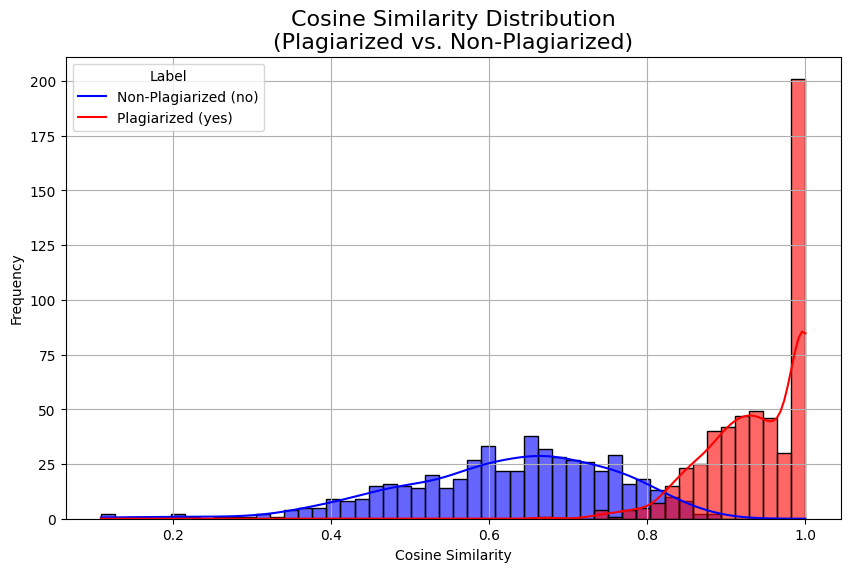

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
def compute_similarity(text1_list, text2_list):
    emb1 = model.encode(text1_list, convert_to_tensor=False)
    emb2 = model.encode(text2_list, convert_to_tensor=False)
    return [util.cos_sim(a, b).item() for a, b in zip(emb1, emb2)]

df['similarity'] = compute_similarity(df['source_doc'].tolist(), df['susp_doc'].tolist())

# STEP 6: Plot similarity distributions
# Assuming your 'label' column has values 'no' and 'yes'
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='similarity', hue='label', bins=50, kde=True,
             palette={'no': 'blue', 'yes': 'red'}, alpha=0.6)  # Changed palette
plt.title('Cosine Similarity Distribution\n(Plagiarized vs. Non-Plagiarized)', fontsize=16)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend(title='Label', labels=['Non-Plagiarized (no)', 'Plagiarized (yes)'])  # Changed labels
plt.grid(True)
plt.show()

#Simple Classifier on Sentence-BERT Similarity

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    df[['similarity']], df['label'], test_size=0.2, random_state=42)
# STEP 7: Train Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

print("🔹 Logistic Regression:")
print(classification_report(y_test, y_pred_log))
print("Accuracy:", accuracy_score(y_test, y_pred_log))


🔹 Logistic Regression:
              precision    recall  f1-score   support

          no       1.00      0.95      0.98       105
         yes       0.96      1.00      0.98       111

    accuracy                           0.98       216
   macro avg       0.98      0.98      0.98       216
weighted avg       0.98      0.98      0.98       216

Accuracy: 0.9768518518518519


In [59]:
from sentence_transformers import SentenceTransformer, util
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score



In [60]:
# STEP 8: Train Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n🔸 Random Forest Classifier:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


🔸 Random Forest Classifier:
              precision    recall  f1-score   support

          no       0.95      0.94      0.95       105
         yes       0.95      0.95      0.95       111

    accuracy                           0.95       216
   macro avg       0.95      0.95      0.95       216
weighted avg       0.95      0.95      0.95       216

Accuracy: 0.9490740740740741


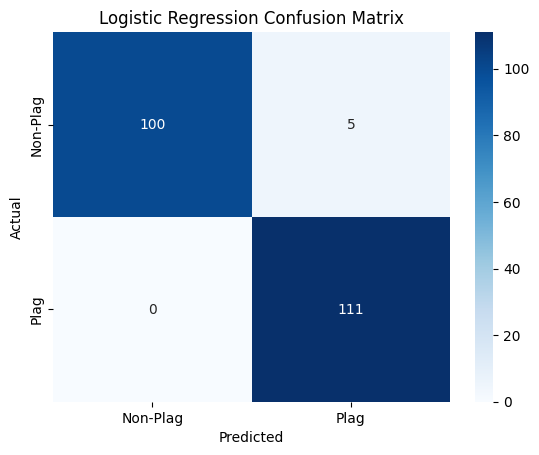

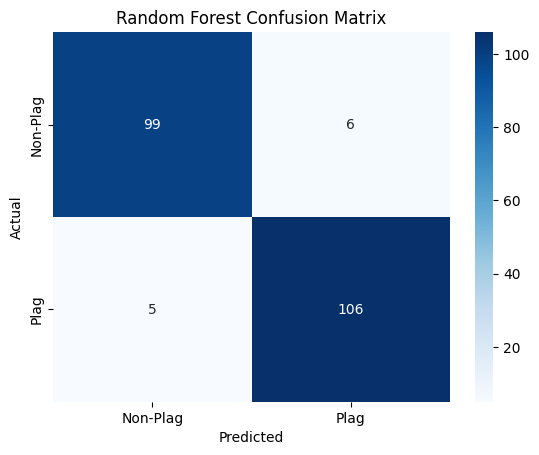

In [61]:
# STEP 9: Visualize Confusion Matrix for both
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Plag', 'Plag'], yticklabels=['Non-Plag', 'Plag'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, y_pred_log, "Logistic Regression Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest Confusion Matrix"
)

In [62]:

# STEP 10: Optional - ROC AUC Score
log_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:,1])
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
print(f"🔍 ROC AUC - Logistic Regression: {log_auc:.3f}")
print(f"🔍 ROC AUC - Random Forest: {rf_auc:.3f}")

🔍 ROC AUC - Logistic Regression: 0.998
🔍 ROC AUC - Random Forest: 0.986


The ROC AUC score measures how well a model distinguishes between classes, with a higher score indicating better performance in correctly identifying positive and negative cases.










#### 🔚 Conclusion

This project aimed to detect trademark and copyright violations using various computer vision and NLP techniques.

- **SSIM** and **ORB** were effective for basic logo comparison, highlighting structural and visual differences.
- **Perceptual hashing (pHash, dHash)** helped match logos with minor edits or resizing.
- **Cosine Similarity with TF-IDF** worked well for text comparison.
- **YOLOv8** successfully detected brand logos in diverse image sets.
- The **Siamese network** outperformed traditional techniques on distorted or resized logos.

This multi-model pipeline enhances robustness in detecting both direct and indirect brand/logo copying.


##Future Improvements

- **CLIP embeddings** to compare visual and text features together.
- **OCR Integration** to detect brand names embedded in images.
- Extend to **audio watermark** or **text plagiarism** detection.
- Add **active learning**: retrain model with user-flagged violations.
- Deploy the full pipeline as an API for real-time trademark scanning.
